In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline


In [4]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True


In [5]:

setup_seed(20)
# download the data
# data pre-processing :The grayscale value is between -1 and 1 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# download the fashion-mnist training dataset and construct the training dataset loader shuffling the data every time 64 images are loaded
trainset = datasets.FashionMNIST('dataset/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
#使用DataLoader加载测试集与训练集，batch_size=64，shuffle=True表示每次加载64个数据，并且每次加载前都会将数据打乱

# download the fashion-mnist test dataset and construct the test dataset loader shuffling the data every time 64 images are loaded
testset = datasets.FashionMNIST('dataset/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Text(0.5, 1.0, 'Bag')

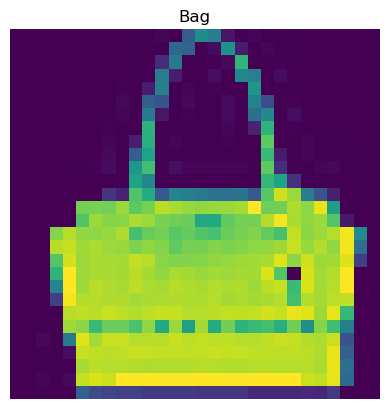

In [8]:
setup_seed(20)
images, labels = next(iter(trainloader))
# this batch has 64 images,we get the first image
imagedemo = images[0]
imagedemolabel = labels[0]
imagedemo = imagedemo.reshape((28,28))
labellist = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
plt.imshow(imagedemo)
plt.axis('off')
plt.title(labellist[imagedemolabel])

In [7]:
setup_seed(20)
# define the ResNet-18 model
class Residual(nn.Module):
    def __init__(self,in_channels,out_channels,strides=1,use_1x1conv=False,**kwargs):
        super(Residual,self).__init__(**kwargs)
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=strides)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        #define the 1x1 convolutional layer to change the shape of the input
        if use_1x1conv:
            self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=strides)
        else:
            self.conv3=None
        self.bn1=nn.BatchNorm2d(out_channels)
        self.bn2=nn.BatchNorm2d(out_channels)
    def forward(self,X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        return F.relu(Y+X)
def resnet_block(in_channels,out_channels,num_residuals,first_block=False):
    if first_block:
        assert in_channels==out_channels
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(in_channels,out_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(out_channels,out_channels))
    return nn.Sequential(*blk)

class ResNet_18(nn.Module):
    def __init__(self):
        super(ResNet_18,self).__init__()
        self.conv=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        self.resnet_block1=resnet_block(64,64,2,first_block=True)
        self.resnet_block2=resnet_block(64,128,2)
        self.resnet_block3=resnet_block(128,256,2)
        self.resnet_block4=resnet_block(256,512,2)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512,10)
    def forward(self,X):
        X=self.conv(X)
        X=self.resnet_block1(X)
        X=self.resnet_block2(X)
        X=self.resnet_block3(X)
        X=self.resnet_block4(X)
        X=self.avgpool(X)
        X=X.reshape(X.shape[0],-1)
        X=self.fc(X)
        return X

In [15]:
#plot every epoch loss and accuracy
def polt_loss_accuracy(train_losses,test_losses,train_accuracy,test_accuracy,boardName):
    #plot the loss and accuracy
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.grid(True, linestyle = "-.", color = "gray", linewidth = "0.5",axis='both')
    plt.title("{}_Training and Validation Loss".format(boardName))
    plt.legend(frameon=False)
    plt.show()

    plt.plot(train_accuracy,label='train accuracy')
    plt.plot(test_accuracy,label='test accuracy')
    plt.grid(True, linestyle = "-.", color = "gray", linewidth = "0.5",axis='both')
    plt.title("{}_BatchSize64_Training and Validation Accuracy".format(boardName))
    plt.legend(frameon=False)
    plt.show()

In [16]:


#batch_size=64
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/resnet18_init')

def train_1(trainloader,testloader,epoch=10,lr=0.003,model_save_path='model.pth',boardName='batch'):
    #define tain function
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet_18()
    # define the loss function and the optimizer
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    # define the loss function
    criterion=nn.CrossEntropyLoss()
    #store the loss of each epoch
    train_losses,test_losses = [],[]
    test_accuracy,train_accuracy=[],[]
    for i in range(epoch):
        if(device=='cuda'):
            model.cuda()
        else:
            model.cpu()
        running_loss=0
        iter_accuracy=0
        accuracy1=0
        for iter,(images,labels) in enumerate(trainloader):
            if(device=='cuda'):
                images,labels=images.cuda(),labels.cuda()
            else:
                images,labels=images.cpu(),labels.cpu()
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            top_p,top_class=outputs.topk(1,dim=1)
            equals=top_class==labels.view(*top_class.shape)
            iter_accuracy=torch.mean(equals.type(torch.FloatTensor))
            accuracy1+=iter_accuracy
            writer.add_scalar('{}_train_loss_iter'.format(boardName),loss.item(),len(trainloader)*i+iter)
            writer.add_scalar('{}_train_accuracy_iter'.format(boardName),iter_accuracy.item(),len(trainloader)*i+iter)
        else:
            test_loss = 0
            iter_accuracy=0
            accuracy2 = 0
            #turn off the gradient
            with torch.no_grad():
                #shut dropout and batch normalization
                model.eval()
                for iter,(images,labels) in enumerate(testloader):
                    if(device=='cuda'):
                        images,labels=images.cuda(),labels.cuda()
                    else:
                        images,labels=images.cpu(),labels.cpu()
                    test_outputs=model(images)
                    loss=criterion(test_outputs,labels)
                    test_loss+=loss.item()
                    #top_p is the probability of the top class,top_class is the index of the top class
                    top_p,top_class=test_outputs.topk(1,dim=1)
                    equals=top_class==labels.view(*top_class.shape)
                    iter_accuracy = torch.mean(equals.type(torch.FloatTensor))
                    accuracy2+=iter_accuracy
                    writer.add_scalar('{}_test_loss_iter'.format(boardName),loss.item(),len(testloader)*i+iter)
                    writer.add_scalar('{}_test_accuracy_iter'.format(boardName),iter_accuracy.item(),len(testloader)*i+iter)
            #turn on the gradient
            model.train()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            train_accuracy.append(accuracy1/len(trainloader))
            test_accuracy.append(accuracy2/len(testloader))
            print("Epoch:{}/{}..".format(i+1,epoch),
                    "Training Loss:{:.3f}..".format(train_losses[-1]),
                    "Test Loss:{:.3f}..".format(test_losses[-1]),
                    "Train Accuracy:{:.3f}".format(train_accuracy[-1]),
                    "Test Accuracy:{:.3f}".format(test_accuracy[-1]))
            
    torch.save(model.state_dict(), model_save_path)
    return train_losses,test_losses,train_accuracy,test_accuracy
    

Epoch:1/5.. Training Loss:0.520.. Test Loss:0.455.. Train Accuracy:0.814 Test Accuracy:0.834
Epoch:2/5.. Training Loss:0.342.. Test Loss:0.321.. Train Accuracy:0.875 Test Accuracy:0.883
Epoch:3/5.. Training Loss:0.300.. Test Loss:0.307.. Train Accuracy:0.889 Test Accuracy:0.893
Epoch:4/5.. Training Loss:0.272.. Test Loss:0.296.. Train Accuracy:0.900 Test Accuracy:0.891
Epoch:5/5.. Training Loss:0.253.. Test Loss:0.273.. Train Accuracy:0.907 Test Accuracy:0.903


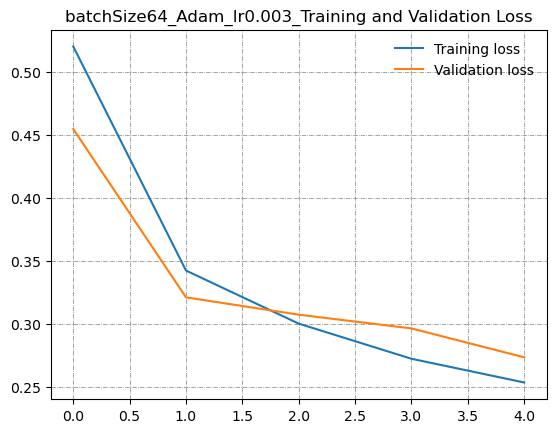

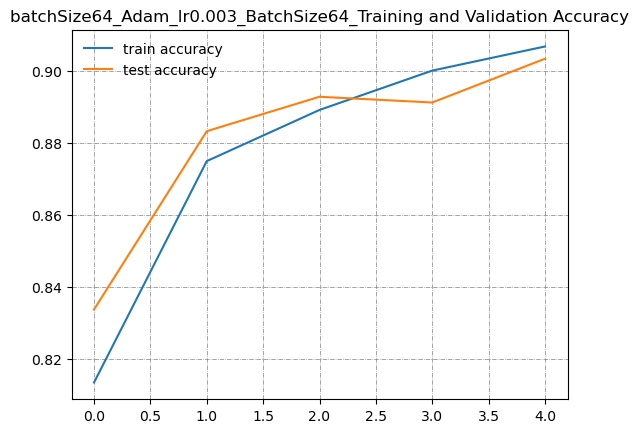

In [17]:
#batch_size=64
setup_seed(20)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
train_losses,test_losses,train_accuracy,test_accuracy = train_1(trainloader,testloader,epoch=5,lr=0.003,model_save_path='batchSize64_Adam_lr0.003.pth',boardName='batchSize64_Adam_lr0.003')
polt_loss_accuracy(train_losses,test_losses,train_accuracy,test_accuracy,boardName='batchSize64_Adam_lr0.003')

Epoch:1/5.. Training Loss:0.518.. Test Loss:0.470.. Train Accuracy:0.812 Test Accuracy:0.824
Epoch:2/5.. Training Loss:0.324.. Test Loss:0.371.. Train Accuracy:0.881 Test Accuracy:0.866
Epoch:3/5.. Training Loss:0.289.. Test Loss:0.327.. Train Accuracy:0.893 Test Accuracy:0.881
Epoch:4/5.. Training Loss:0.256.. Test Loss:0.335.. Train Accuracy:0.906 Test Accuracy:0.881
Epoch:5/5.. Training Loss:0.237.. Test Loss:0.305.. Train Accuracy:0.913 Test Accuracy:0.888


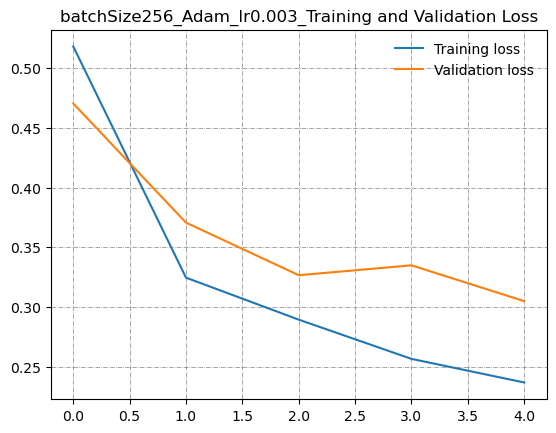

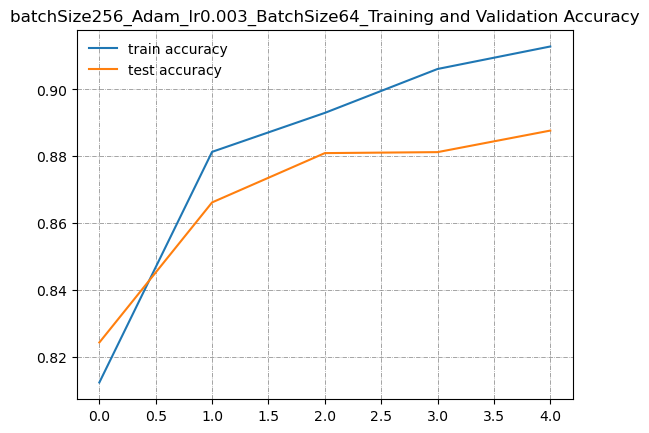

In [18]:
# batch_size=256
setup_seed(20)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)
train_losses2,test_losses2,train_accuracy2,test_accuracy2 = train_1(trainloader,testloader,epoch=5,lr=0.003,model_save_path='batchSize256_Adam_lr0.003.pth',boardName='batchSize256_Adam_lr0.003')
polt_loss_accuracy(train_losses2,test_losses2,train_accuracy2,test_accuracy2,boardName='batchSize256_Adam_lr0.003')

Epoch:1/5.. Training Loss:1.227.. Test Loss:0.624.. Train Accuracy:0.638 Test Accuracy:0.764
Epoch:2/5.. Training Loss:0.475.. Test Loss:0.523.. Train Accuracy:0.824 Test Accuracy:0.820
Epoch:3/5.. Training Loss:0.377.. Test Loss:0.478.. Train Accuracy:0.862 Test Accuracy:0.822
Epoch:4/5.. Training Loss:0.333.. Test Loss:0.434.. Train Accuracy:0.878 Test Accuracy:0.844
Epoch:5/5.. Training Loss:0.307.. Test Loss:0.330.. Train Accuracy:0.887 Test Accuracy:0.882


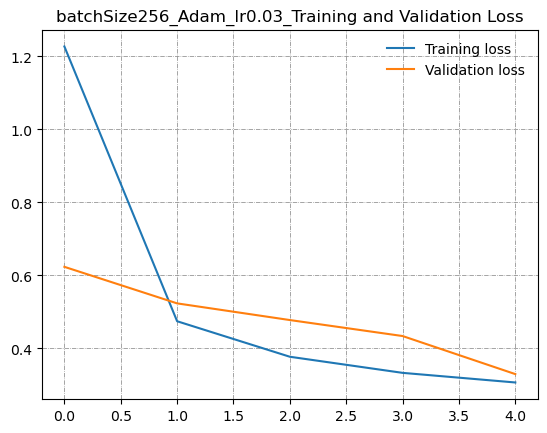

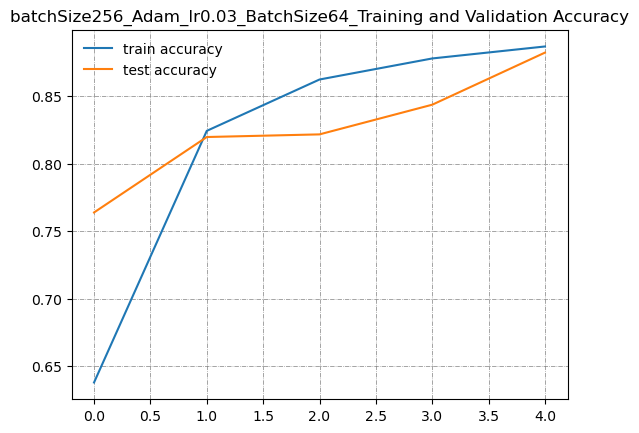

In [19]:
#diferent lr 0.03
setup_seed(20)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)
train_losses3,test_losses3,train_accuracy3,test_accuracy3 = train_1(trainloader,testloader,epoch=5,lr=0.03,model_save_path='batchSize256_Adam_lr0.03.pth',boardName='batchSize256_Adam_lr0.03')
polt_loss_accuracy(train_losses3,test_losses3,train_accuracy3,test_accuracy3,boardName='batchSize256_Adam_lr0.03')

Epoch:1/5.. Training Loss:0.422.. Test Loss:0.331.. Train Accuracy:0.845 Test Accuracy:0.875
Epoch:2/5.. Training Loss:0.286.. Test Loss:0.338.. Train Accuracy:0.894 Test Accuracy:0.883
Epoch:3/5.. Training Loss:0.245.. Test Loss:0.303.. Train Accuracy:0.909 Test Accuracy:0.887
Epoch:4/5.. Training Loss:0.213.. Test Loss:0.344.. Train Accuracy:0.919 Test Accuracy:0.873
Epoch:5/5.. Training Loss:0.189.. Test Loss:0.310.. Train Accuracy:0.929 Test Accuracy:0.889


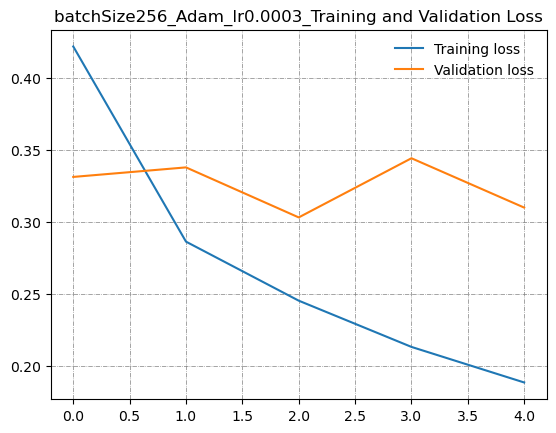

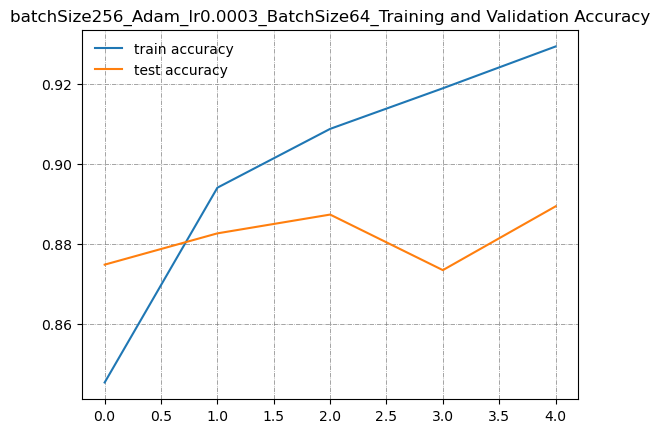

In [20]:
#diferent lr 0.0003
setup_seed(20)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)
train_losses4,test_losses4,train_accuracy4,test_accuracy4 = train_1(trainloader,testloader,epoch=5,lr=0.0003,model_save_path='batchSize256_Adam_lr0.0003.pth',boardName='batchSize256_Adam_lr0.0003')
polt_loss_accuracy(train_losses4,test_losses4,train_accuracy4,test_accuracy4,boardName='batchSize256_Adam_lr0.0003')

In [21]:

def train_SGD(trainloader,testloader,epoch=10,lr=0.003,model_save_path='model.pth',boardName='batch'):
    #define tain function
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet_18()
    # define the loss function and the optimizer
    optimizer=torch.optim.SGD(model.parameters(),lr=lr)
    # define the loss function
    criterion=nn.CrossEntropyLoss()
    #store the loss of each epoch
    train_losses,test_losses = [],[]
    test_accuracy,train_accuracy=[],[]
    for i in range(epoch):
        if(device=='cuda'):
            model.cuda()
        else:
            model.cpu()
        running_loss=0
        iter_accuracy=0
        accuracy1=0
        for iter,(images,labels) in enumerate(trainloader):
            if(device=='cuda'):
                images,labels=images.cuda(),labels.cuda()
            else:
                images,labels=images.cpu(),labels.cpu()
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            top_p,top_class=outputs.topk(1,dim=1)
            equals=top_class==labels.view(*top_class.shape)
            iter_accuracy=torch.mean(equals.type(torch.FloatTensor))
            accuracy1+=iter_accuracy
            writer.add_scalar('{}_train_loss_iter'.format(boardName),loss.item(),len(trainloader)*i+iter)
            writer.add_scalar('{}_train_accuracy_iter'.format(boardName),iter_accuracy.item(),len(trainloader)*i+iter)
        else:
            test_loss = 0
            iter_accuracy=0
            accuracy2 = 0
            #turn off the gradient
            with torch.no_grad():
                #shut dropout and batch normalization
                model.eval()
                for iter,(images,labels) in enumerate(testloader):
                    if(device=='cuda'):
                        images,labels=images.cuda(),labels.cuda()
                    else:
                        images,labels=images.cpu(),labels.cpu()
                    test_outputs=model(images)
                    loss=criterion(test_outputs,labels)
                    test_loss+=loss.item()
                    #top_p is the probability of the top class,top_class is the index of the top class
                    top_p,top_class=test_outputs.topk(1,dim=1)
                    equals=top_class==labels.view(*top_class.shape)
                    iter_accuracy = torch.mean(equals.type(torch.FloatTensor))
                    accuracy2+=iter_accuracy
                    writer.add_scalar('{}_test_loss_iter'.format(boardName),loss.item(),len(testloader)*i+iter)
                    writer.add_scalar('{}_test_accuracy_iter'.format(boardName),iter_accuracy.item(),len(testloader)*i+iter)
            #turn on the gradient
            model.train()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            train_accuracy.append(accuracy1/len(trainloader))
            test_accuracy.append(accuracy2/len(testloader))
            print("Epoch:{}/{}..".format(i+1,epoch),
                    "Training Loss:{:.3f}..".format(train_losses[-1]),
                    "Test Loss:{:.3f}..".format(test_losses[-1]),
                    "Train Accuracy:{:.3f}".format(train_accuracy[-1]),
                    "Test Accuracy:{:.3f}".format(test_accuracy[-1]))
            
    torch.save(model.state_dict(), model_save_path)
    return train_losses,test_losses,train_accuracy,test_accuracy

Epoch:1/5.. Training Loss:0.544.. Test Loss:0.451.. Train Accuracy:0.813 Test Accuracy:0.833
Epoch:2/5.. Training Loss:0.323.. Test Loss:0.387.. Train Accuracy:0.883 Test Accuracy:0.862
Epoch:3/5.. Training Loss:0.254.. Test Loss:0.381.. Train Accuracy:0.909 Test Accuracy:0.860
Epoch:4/5.. Training Loss:0.202.. Test Loss:0.381.. Train Accuracy:0.929 Test Accuracy:0.862
Epoch:5/5.. Training Loss:0.159.. Test Loss:0.396.. Train Accuracy:0.945 Test Accuracy:0.864


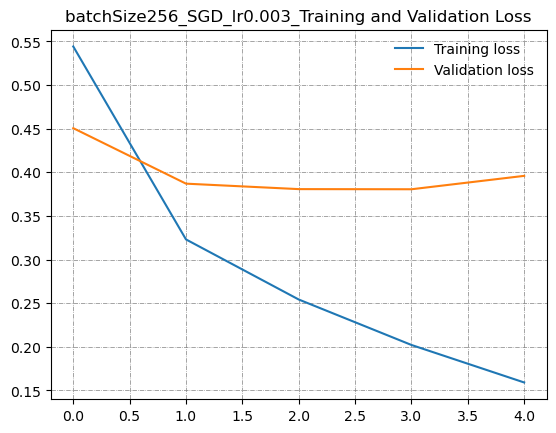

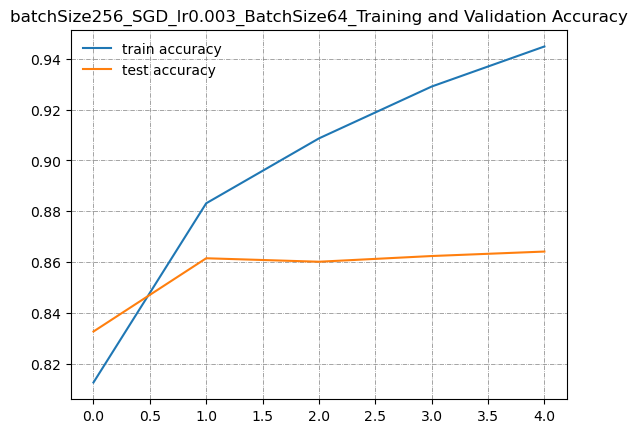

In [22]:
#SGD
setup_seed(20)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)
train_losses5,test_losses5,train_accuracy5,test_accuracy5 = train_SGD(trainloader,testloader,epoch=5,lr=0.003,model_save_path='batchSize256_SGD_lr0.003.pth',boardName='batchSize256_SGD_lr0.003')
polt_loss_accuracy(train_losses5,test_losses5,train_accuracy5,test_accuracy5,boardName='batchSize256_SGD_lr0.003')


In [26]:
def train_RMSprop(trainloader,testloader,epoch=10,lr=0.003,model_save_path='model.pth',boardName='batch'):
    #define tain function
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet_18()
    # define the loss function and the optimizer
    optimizer=torch.optim.RMSprop(model.parameters(),lr=lr)
    # define the loss function
    criterion=nn.CrossEntropyLoss()
    #store the loss of each epoch
    train_losses,test_losses = [],[]
    test_accuracy,train_accuracy=[],[]
    for i in range(epoch):
        if(device=='cuda'):
            model.cuda()
        else:
            model.cpu()
        running_loss=0
        iter_accuracy=0
        accuracy1=0
        for iter,(images,labels) in enumerate(trainloader):
            if(device=='cuda'):
                images,labels=images.cuda(),labels.cuda()
            else:
                images,labels=images.cpu(),labels.cpu()
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            top_p,top_class=outputs.topk(1,dim=1)
            equals=top_class==labels.view(*top_class.shape)
            iter_accuracy=torch.mean(equals.type(torch.FloatTensor))
            accuracy1+=iter_accuracy
            writer.add_scalar('{}_train_loss_iter'.format(boardName),loss.item(),len(trainloader)*i+iter)
            writer.add_scalar('{}_train_accuracy_iter'.format(boardName),iter_accuracy.item(),len(trainloader)*i+iter)
        else:
            test_loss = 0
            iter_accuracy=0
            accuracy2 = 0
            #turn off the gradient
            with torch.no_grad():
                #shut dropout and batch normalization
                model.eval()
                for iter,(images,labels) in enumerate(testloader):
                    if(device=='cuda'):
                        images,labels=images.cuda(),labels.cuda()
                    else:
                        images,labels=images.cpu(),labels.cpu()
                    test_outputs=model(images)
                    loss=criterion(test_outputs,labels)
                    test_loss+=loss.item()
                    #top_p is the probability of the top class,top_class is the index of the top class
                    top_p,top_class=test_outputs.topk(1,dim=1)
                    equals=top_class==labels.view(*top_class.shape)
                    iter_accuracy = torch.mean(equals.type(torch.FloatTensor))
                    accuracy2+=iter_accuracy
                    writer.add_scalar('{}_test_loss_iter'.format(boardName),loss.item(),len(testloader)*i+iter)
                    writer.add_scalar('{}_test_accuracy_iter'.format(boardName),iter_accuracy.item(),len(testloader)*i+iter)
            #turn on the gradient
            model.train()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            train_accuracy.append(accuracy1/len(trainloader))
            test_accuracy.append(accuracy2/len(testloader))
            print("Epoch:{}/{}..".format(i+1,epoch),
                    "Training Loss:{:.3f}..".format(train_losses[-1]),
                    "Test Loss:{:.3f}..".format(test_losses[-1]),
                    "Train Accuracy:{:.3f}".format(train_accuracy[-1]),
                    "Test Accuracy:{:.3f}".format(test_accuracy[-1]))
            
    torch.save(model.state_dict(), model_save_path)
    return train_losses,test_losses,train_accuracy,test_accuracy

Epoch:1/5.. Training Loss:1.058.. Test Loss:10.054.. Train Accuracy:0.685 Test Accuracy:0.524
Epoch:2/5.. Training Loss:0.454.. Test Loss:0.500.. Train Accuracy:0.833 Test Accuracy:0.824
Epoch:3/5.. Training Loss:0.369.. Test Loss:0.506.. Train Accuracy:0.864 Test Accuracy:0.823
Epoch:4/5.. Training Loss:0.323.. Test Loss:0.493.. Train Accuracy:0.880 Test Accuracy:0.832
Epoch:5/5.. Training Loss:0.283.. Test Loss:0.633.. Train Accuracy:0.894 Test Accuracy:0.807


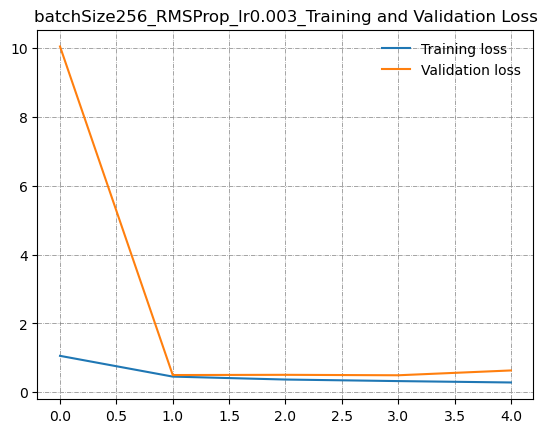

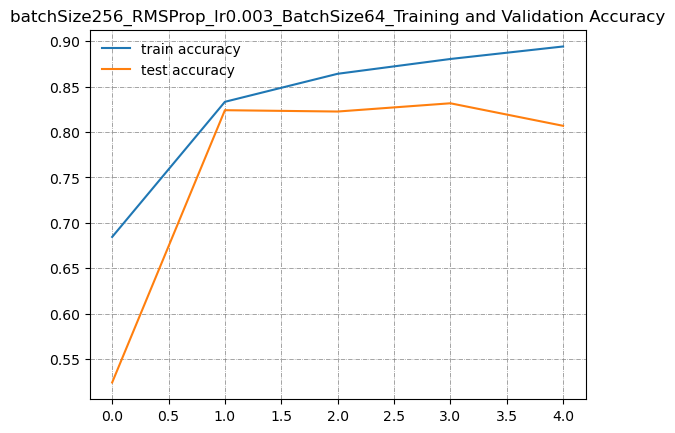

In [27]:
#RMSProp
setup_seed(20)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)
train_losses6,test_losses6,train_accuracy6,test_accuracy6 = train_RMSprop(trainloader,testloader,epoch=5,lr=0.003,model_save_path='batchSize256_RMSProp_lr0.003.pth',boardName='batchSize256_RMSProp_lr0.003')
polt_loss_accuracy(train_losses6,test_losses6,train_accuracy6,test_accuracy6,boardName='batchSize256_RMSProp_lr0.003')

In [36]:
#show prediction
def display_prediction(model,testloader,title):
    model.eval()
    fig,axs = plt.subplots(3,3,figsize=(8,8))
    for i,ax in enumerate(axs.flat):
        images,labels = next(iter(testloader))
        outputs = model(images)
        top_p,top_class = outputs.topk(1,dim=1)
        ax.imshow(images[i].view(28,28))
        labellist = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
        ax.set_title('pre:{}   true:{} '.format(labellist[top_class[i].item()],labellist[labels[i]]))
        ax.axis('off')
    fig.suptitle('{}'.format(title))
    plt.show()
def show_diferent_model(title):
    #display prediction image
    setup_seed(20)
    model = ResNet_18()
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
    model.load_state_dict(torch.load('{}.pth'.format(title)))
    display_prediction(model,testloader,title)   

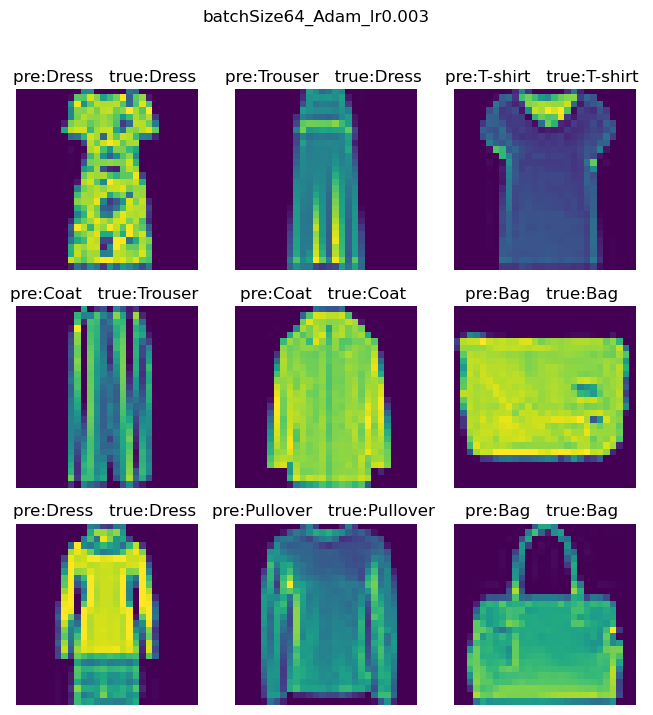

In [39]:
title = 'batchSize64_Adam_lr0.003'
show_diferent_model(title) 

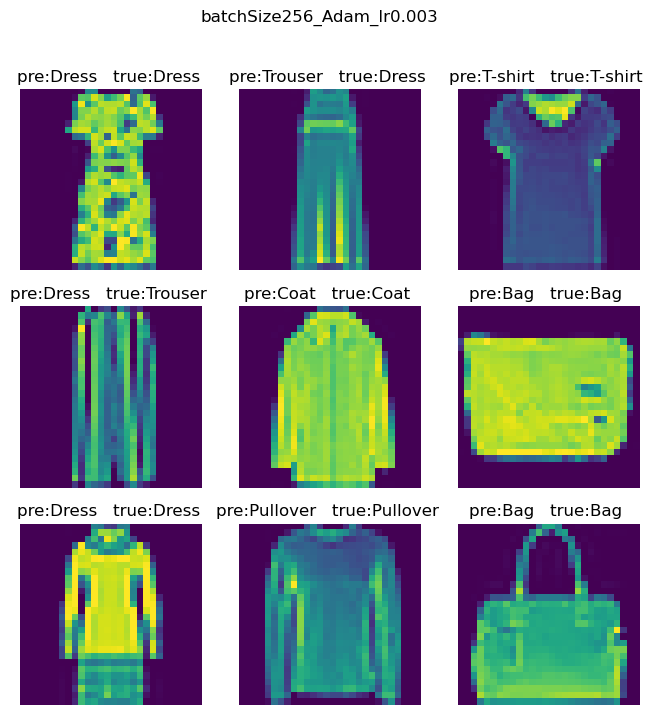

In [40]:
title = 'batchSize256_Adam_lr0.003'
show_diferent_model(title) 

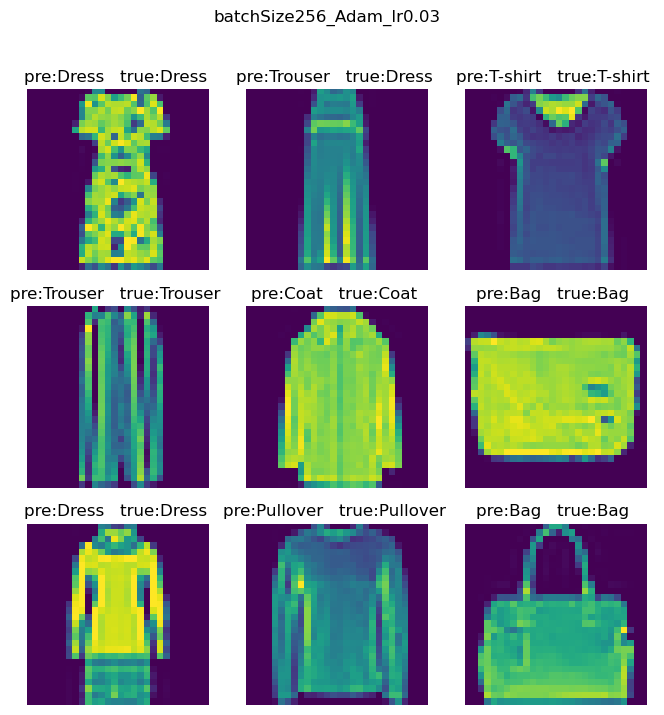

In [41]:
title = 'batchSize256_Adam_lr0.03'
show_diferent_model(title) 

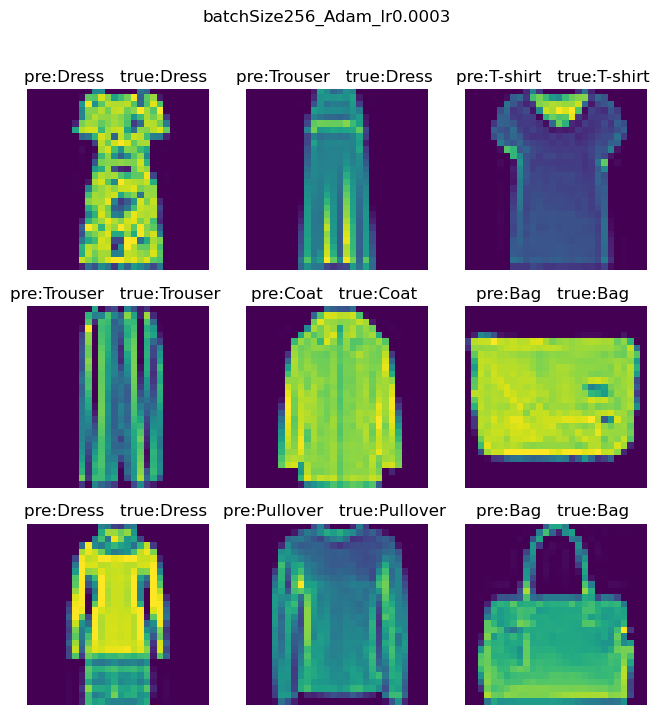

In [43]:
title = 'batchSize256_Adam_lr0.0003'
show_diferent_model(title) 

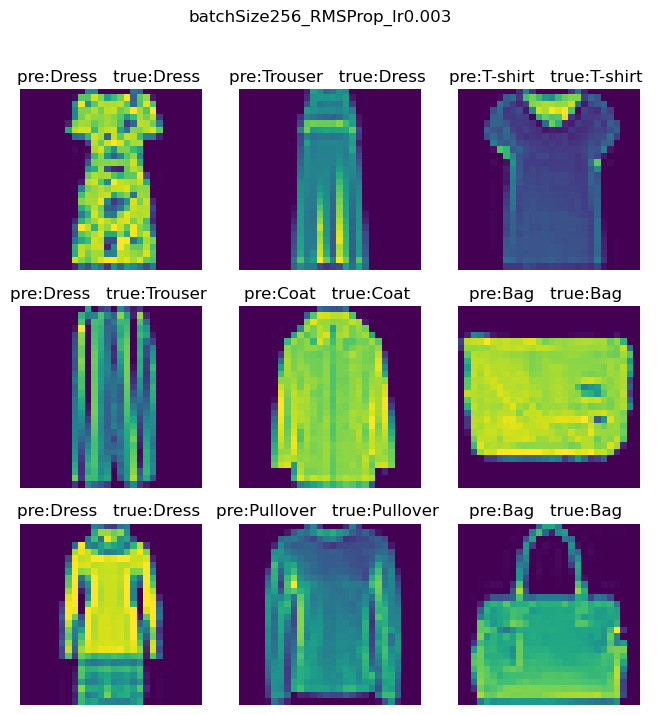

In [44]:
title = 'batchSize256_RMSProp_lr0.003'
show_diferent_model(title) 

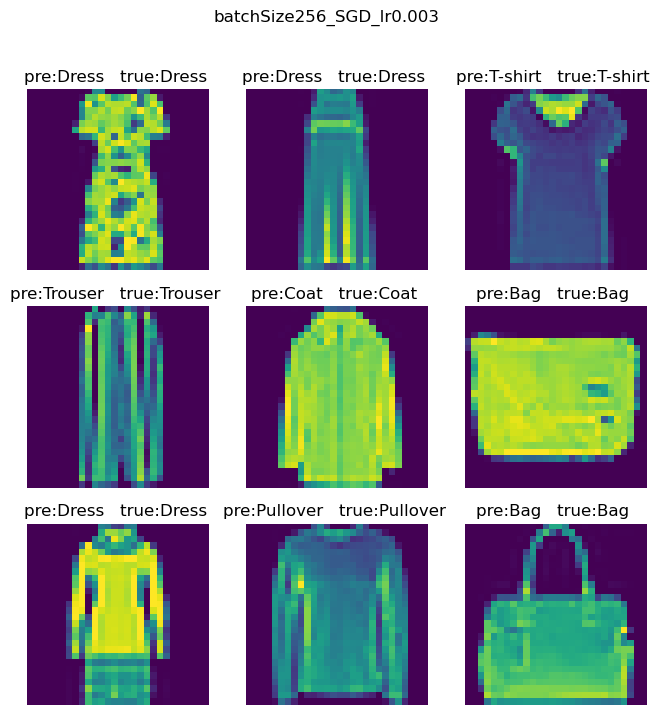

In [45]:
title = 'batchSize256_SGD_lr0.003'
show_diferent_model(title) 